In this notebook, we explore the decision tree model and tune the hyperparameters. We work with two different training sets, each with the a different subset of features. 
- train_1 contains features which were found by scraping a website of all food-related words.
- train_2 contains features which were found by picking ingredients which occured at least 50 times in the training data. 

In [81]:
## Import packages 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [3]:
## Import data
#train_0 = pd.read_csv("../Data/original_data.csv") # This line runs very slowly on my computer and using train_0 always leads to python kernel crashing
train_1 = pd.read_csv("../Data/key_words_data.csv")
train_2 = pd.read_csv("../Data/train_trimmed.csv")

train_list = { 1:train_1, 2:train_2} #Do one at a time in case the kernel crashes

## Tuning the depth and n_estimators of a random forest

In [ ]:
# Range of all hyperparameters
max_depth_list = range(200,201,30)
n_estimators_list = range(60,80,5)
hyperparameter_list = product(max_depth_list,n_estimators_list)

# List of all KPI metrics
cv_accuracy_score = {i:{} for i in train_list}
cv_recall_score = {i:{} for i in train_list}
cv_f1_score = {i:{} for i in train_list}

## Make stratified k fold splits of the data
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=429)

## Use cross-validation to tune the hyperparameters
for i,train in train_list.items(): 
    X_train = train.drop(columns=["id","cuisine"])
    y_train = train["cuisine"]
    
    for hyperparameter in hyperparameter_list: 
        max_depth, n_estimators = hyperparameter
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        
        ## To store KPI metrics for each of the 5 cross-validation sets
        accuracy_list = []
        f1_list = []
        recall_list = []
        
        for train_idx, test_idx in skf.split(X_train,y_train):
            X_train_train, y_train_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_holdout, y_holdout = X_train.iloc[test_idx], y_train.iloc[test_idx]
            clf.fit(X_train_train,y_train_train)
            prediction = clf.predict(X_holdout)
            accuracy_list.append(accuracy_score(y_holdout,prediction))
            f1_list.append(f1_score(y_holdout,prediction,average="weighted"))
            recall_list.append(recall_score(y_holdout,prediction,average="weighted"))
            
        cv_accuracy_score[i][hyperparameter] = np.mean(accuracy_list)
        cv_f1_score[i][hyperparameter] = np.mean(f1_list)
        cv_recall_score[i][hyperparameter] = np.mean(recall_list)

        print("Train set",i,". Done with parameters ", hyperparameter, 
              ". Accuracy = ", cv_accuracy_score[i][hyperparameter]) #Output to keep track of the process

## Results
Due to computational intensity, we tuned the hyperparameters by fixing one and varying the other. We did this repeatedly for a few times to arrive at the near-optimal values of: 
- train_1 - max_depth=50, n_estimators=75 gives an accuracy of 71%
- train_2 - max_depth=200, n_estimators=65 gives 70.3% accuracy

## Findings about the final models

In [27]:
#Train the models again
clf_1 = RandomForestClassifier(max_depth=50,n_estimators=75) 
clf_2 = RandomForestClassifier(max_depth=200,n_estimators=65)

X_1 = train_1.drop(columns=["id","cuisine"])
y_1 = train_1["cuisine"]
X_2 = train_2.drop(columns=["id","cuisine"])
y_2 = train_2["cuisine"]

clf_1.fit(X_1,y_1)
clf_2.fit(X_2,y_2)

RandomForestClassifier(max_depth=200, n_estimators=65)

In [46]:
cuisine_list = np.unique(y_1.values)
cuisine_list = sorted(cuisine_list, key = lambda c: np.sum(train_1["cuisine"] == c),reverse=True) #Sort by descending order
cuisine_list

['italian',
 'mexican',
 'southern_us',
 'indian',
 'chinese',
 'french',
 'cajun_creole',
 'thai',
 'japanese',
 'greek',
 'spanish',
 'korean',
 'vietnamese',
 'moroccan',
 'british',
 'filipino',
 'irish',
 'jamaican',
 'russian',
 'brazilian']

In [47]:
# Feature importance of the random_forests
feature_importances_1 = pd.DataFrame(np.transpose([X_1.columns,clf_1.feature_importances_]),
                                    columns=["ingredient","importance"])
feature_importances_1_top10 = feature_importances_1.sort_values(by="importance"
                                                                ,ascending=False).head(10)

def ingredient_count(ing,c,df): #Return count of ingredient ing in cusine c in dataframe df
    return np.sum((df[ing] == 1) & (df["cuisine"] == c))
    
for c in cuisine_list: 
    feature_importances_1_top10[c] = feature_importances_1_top10["ingredient"].apply(lambda ing: ingredient_count(ing,c,train_1))
    
feature_importances_1_top10

,ingredient,importance,italian,mexican,southern_us,indian,chinese,french,cajun_creole,thai,...,spanish,korean,vietnamese,moroccan,british,filipino,irish,jamaican,russian,brazilian
95,cheese,0.027748,4073,2494,737,58,30,449,149,11,...,78,12,2,18,101,35,77,16,59,49
529,sauce,0.022597,415,896,363,43,2124,38,232,518,...,21,551,303,11,20,294,12,104,10,18
380,cilantro,0.020904,48,2643,55,1019,243,13,24,693,...,82,16,326,278,5,16,5,32,9,83
287,gin,0.0193,33,33,60,1320,1291,31,8,491,...,7,289,204,109,27,99,14,92,10,31
375,chili,0.019227,73,2479,204,1090,282,9,120,361,...,57,96,162,27,7,50,2,45,8,32
82,tortilla,0.018992,5,1647,5,6,2,0,3,9,...,5,10,2,0,0,0,0,3,1,1
369,basil,0.01659,1878,61,76,15,34,146,92,326,...,35,2,159,9,4,2,3,8,5,2
141,lime,0.016573,42,2021,121,245,74,27,20,889,...,57,11,350,15,5,27,4,131,0,148
54,oil,0.01607,4828,2823,1220,1959,2155,965,788,954,...,699,618,474,617,205,461,135,264,190,224
67,salt,0.015684,4847,3782,2999,2380,1224,1769,968,604,...,659,376,405,594,552,465,462,395,362,252


In [51]:
# Feature importance of the random_forests
feature_importances_2 = pd.DataFrame(np.transpose([X_2.columns,clf_2.feature_importances_]),
                                    columns=["ingredient","importance"])
feature_importances_2_top10 = feature_importances_2.sort_values(by="importance",ascending=False).head(10)
 
for c in cuisine_list: 
    feature_importances_2_top10[c] = feature_importances_2_top10["ingredient"].apply(lambda ing: ingredient_count(ing,c,train_2))
    
feature_importances_2_top10

,ingredient,importance,italian,mexican,southern_us,indian,chinese,french,cajun_creole,thai,...,spanish,korean,vietnamese,moroccan,british,filipino,irish,jamaican,russian,brazilian
13,soy sauce,0.014956,15,42,21,20,1363,5,12,332,...,3,427,155,4,2,251,7,67,3,1
29,grated parmesan cheese,0.014114,1579,33,82,1,3,74,38,1,...,6,0,1,3,7,1,4,2,0,12
2,olive oil,0.01203,3111,1289,312,359,135,516,316,114,...,387,36,38,412,54,48,50,66,50,118
79,corn tortillas,0.010657,1,946,1,1,2,0,1,2,...,3,5,0,0,0,0,0,1,0,1
87,garam masala,0.01064,1,0,2,862,1,0,0,2,...,0,0,0,6,2,0,0,2,0,1
0,salt,0.010209,3454,2720,2290,1934,907,1203,743,396,...,460,253,264,413,407,421,376,332,288,194
57,fish sauce,0.009965,2,2,0,6,63,0,0,625,...,0,48,392,0,0,98,0,0,0,2
20,ground cumin,0.009306,30,1346,52,683,7,15,40,50,...,55,0,8,348,5,7,2,20,4,20
95,flour tortillas,0.008868,11,818,4,2,9,1,3,6,...,3,0,1,0,0,2,1,2,0,0
59,avocado,0.008734,25,1043,12,2,8,3,3,12,...,20,1,11,2,0,3,2,6,1,10


In [97]:
## Now we analayze the misclassification error

# Make a train-test split
train_train_1, test_1 = train_test_split(train_1, stratify = train_1["cuisine"],test_size=0.2,shuffle=True)
X_train_1 = train_train_1.drop(columns=["id","cuisine"])
y_train_1 = train_train_1["cuisine"]
X_test_1 = test_1.drop(columns=["id","cuisine"])
y_test_1 = test_1["cuisine"]

# Train a classifier
clf_1 = RandomForestClassifier(max_depth=50,n_estimators=75)
clf_1.fit(X_train_1,y_train_1)

# Predict on the test
predicted = clf_1.predict(X_test_1)
actual = y_test_1

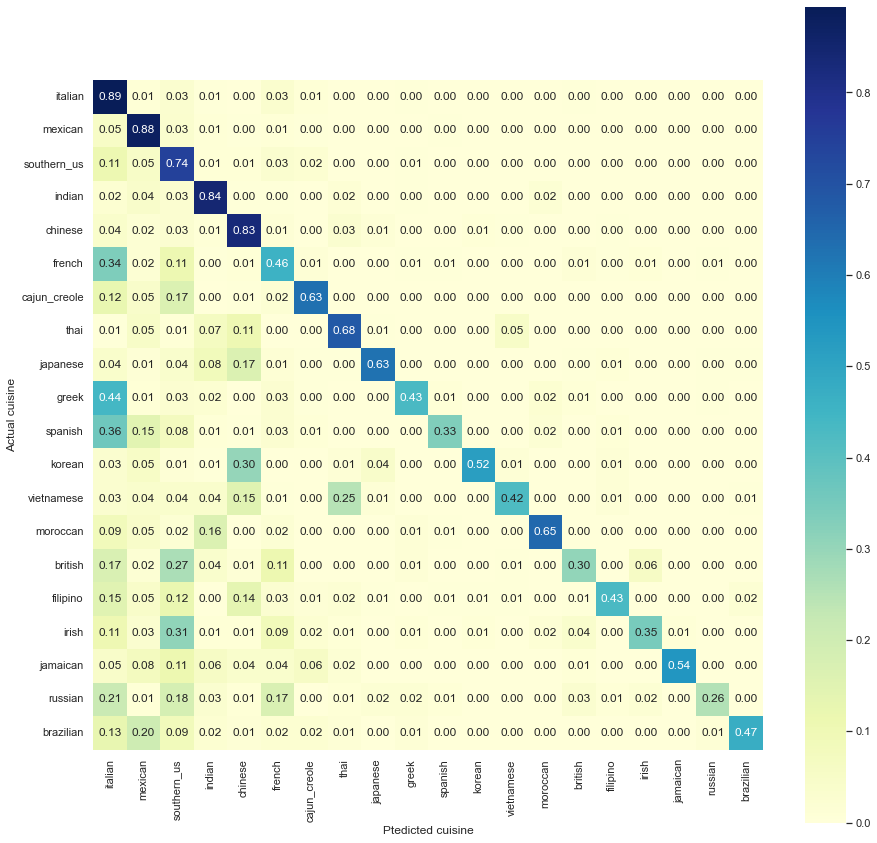

In [146]:
np.sum(predicted == actual)/len(actual) #71% accuracy

conf_mat = confusion_matrix(actual,predicted,labels=cuisine_list) #Confusion matrix
conf_mat_normalized = conf_mat/conf_mat.sum(axis=1)[:,np.newaxis]

##Plot heat plot
sns.set(rc={"figure.figsize":(15, 15)}) #set figure size
plt.plot(figsize=(15,15))
sns.heatmap(conf_mat_normalized,square=True, fmt='.2f', cmap="YlGnBu",
            xticklabels=cuisine_list,yticklabels=cuisine_list,annot=True)
plt.xlabel("Ptedicted cuisine")
plt.ylabel("Actual cuisine")
plt.show()

## Final Model performance

In [156]:
clf_1 = RandomForestClassifier(max_depth=50,n_estimators=75) 
clf_2 = RandomForestClassifier(max_depth=200,n_estimators=65)

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=429)

for i, clf, train in [(1,clf_1, train_1), (2,clf_2,train_2)]:
    X_train = train.drop(columns=["id","cuisine"])
    y_train = train["cuisine"]
    accuracy_list = []
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_train, y_train_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_holdout, y_holdout = X_train.iloc[test_idx], y_train.iloc[test_idx]
        clf.fit(X_train_train,y_train_train)
        prediction = clf.predict(X_holdout)
        accuracy_list.append(accuracy_score(y_holdout,prediction))
            
    cv_accuracy_score = np.mean(accuracy_list)
    print("For random forest on train_",str(i), " the accuracy is :", cv_accuracy_score,".")


For random forest on train_ 1  the accuracy is : 0.7121989845129292 .
For random forest on train_ 2  the accuracy is : 0.7024941401746403 .


In [ ]:
## Results: 
# For random seed = 429, the performances are: 
# * train_1 -> 71.06
# * train_2 -> 70.11

# For random seed = 2205, the performance are: 
# * train_1 -> 71.14
# * train_2 -> 70.22